In [21]:
import lightning as pl
import logging
from torch.utils.data import DataLoader, Subset
import pandas as pd
from tqdm import tqdm
import numpy as np

from neural_bandits.bandits.linear_ucb_bandit import LinearUCBBandit
from neural_bandits.bandits.linear_ts_bandit import LinearTSBandit
from neural_bandits.benchmark.datasets.statlog import StatlogDataset

from neural_bandits.benchmark.environment import BanditBenchmarkEnvironment

In [22]:
dataset = StatlogDataset()
print(dataset.context_size)
print(len(dataset))

63
58000


In [23]:
from neural_bandits.utils.selectors import EpsilonGreedySelector

train_loader = DataLoader(Subset(dataset, range(5000)), batch_size=32, shuffle=True)

accelerator = "cpu"
env = BanditBenchmarkEnvironment(train_loader, device=accelerator)

bandit_module = LinearTSBandit(
    n_features=dataset.context_size,
    selector=EpsilonGreedySelector(0.1),
    lazy_uncertainty_update=True,
).to(accelerator)

logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.FATAL)

In [24]:
rewards = np.array([])
regrets = np.array([])
progress = tqdm(iter(env), total=len(env))
for contextualized_actions in progress:
    chosen_actions, _ = bandit_module.forward(contextualized_actions)

    trainer = pl.Trainer(
        max_epochs=1,
        enable_progress_bar=False,
        enable_model_summary=False,
        accelerator=accelerator,
    )
    chosen_contextualized_actions, realized_rewards = env.get_feedback(chosen_actions)
    batch_regret = env.compute_regret(chosen_actions)

    rewards = np.append(rewards, realized_rewards.cpu().numpy())
    regrets = np.append(regrets, batch_regret.cpu().numpy())
    
    progress.set_postfix({"reward": realized_rewards.mean().item(), "regret": realized_rewards.mean().item(), "avg_regret": regrets.mean()})

    bandit_module.record_feedback(chosen_contextualized_actions, realized_rewards)
    trainer.fit(bandit_module)
    # Because of this: https://github.com/Lightning-AI/pytorch-lightning/issues/10294,
    # we need to move the model to the desired device.
    bandit_module = bandit_module.to(accelerator)
metrics = pd.DataFrame({
    "reward": rewards,
    "regret": regrets,
})
metrics

  0%|          | 0/157 [00:00<?, ?it/s, reward=0.0625, regret=0.0625, avg_regret=0.938]c:\Users\Philipp\miniconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\core\optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
c:\Users\Philipp\miniconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\Philipp\miniconda3\envs\neural_bandits\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
100%|██████████| 157/157 [00:37<00:00,  4.19it/s, reward=0.75, regret=0.75, avg_regret=0

,reward,regret
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
4995,1.0,0.0
4996,1.0,0.0
4997,1.0,0.0
4998,0.0,1.0


In [28]:
# load metrics from the logger and plot
import pandas as pd
import numpy as np

cumulative_reward = np.cumsum(metrics["reward"][:5000])
cumulative_regret = np.cumsum(metrics["regret"][:5000].dropna())

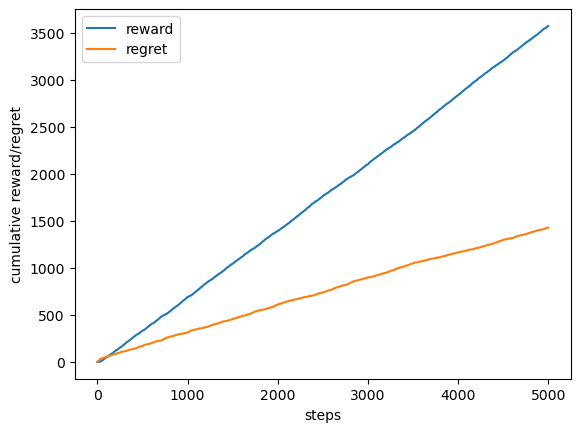

In [29]:
import matplotlib.pyplot as plt

plt.plot(cumulative_reward, label="reward")
plt.plot(cumulative_regret, label="regret")
plt.xlabel("steps")
plt.ylabel("cumulative reward/regret")
plt.legend()
plt.show()

In [30]:
# average reward
print(sum(metrics["reward"][:100]) / 100)
print(sum(metrics["reward"][:1000]) / 1000)
print(sum(metrics["reward"][:10000]) / 10000)
print(sum(metrics["regret"][:100].dropna()) / 100)
print(sum(metrics["regret"][:1000].dropna()) / 1000)
print(sum(metrics["regret"][:10000].dropna()) / 10000)

0.47
0.688
0.3572
0.53
0.312
0.1428
